In [ ]:
!pip install yfinance tensorflow transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 43.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from transformers import GPT2LMHeadModel, GPT2Tokenizer
import torch

# GRU Model for Stock Price Prediction
def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start=start_date, end=end_date)
    return stock_data

def prepare_data(stock_data, lookback=60):
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(stock_data['Close'].values.reshape(-1, 1))

    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))
    return X, y, scaler

def build_gru_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(50, return_sequences=True, input_shape=input_shape),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.GRU(50, return_sequences=False),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def predict_future_prices(model, stock_data, scaler, future_days=30):
    lookback = 60  # Same as in prepare_data
    last_sequence = stock_data['Close'].values[-lookback:]
    last_sequence_scaled = scaler.transform(last_sequence.reshape(-1, 1))

    future_predictions = []
    for _ in range(future_days):
        # Predict the next day's price
        next_day_scaled = model.predict(last_sequence_scaled[-lookback:].reshape(1, lookback, 1))
        future_predictions.append(next_day_scaled[0][0])
        # Update the sequence with the predicted value
        last_sequence_scaled = np.append(last_sequence_scaled, next_day_scaled)

    # Inverse transform the predictions to get actual prices
    future_prices = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    return future_prices

def predict_stock_price(ticker, start_date, end_date, future_days=0):
    stock_data = get_stock_data(ticker, start_date, end_date)
    X, y, scaler = prepare_data(stock_data)

    model = build_gru_model((X.shape[1], 1))
    model.fit(X, y, batch_size=32, epochs=10, verbose=1)

    if future_days > 0:
        # Predict future prices
        future_prices = predict_future_prices(model, stock_data, scaler, future_days)
        return future_prices
    else:
        # Predict the next day's price
        last_sequence = X[-1].reshape(1, X.shape[1], 1)
        predicted_scaled = model.predict(last_sequence)
        predicted_price = scaler.inverse_transform(predicted_scaled)
        return predicted_price[0][0]

# GPT-3 for Chatbot Responses
def generate_gpt3_response(prompt):
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    model = GPT2LMHeadModel.from_pretrained("gpt2")

    inputs = tokenizer.encode(prompt, return_tensors="pt")
    outputs = model.generate(inputs, max_length=100, num_return_sequences=1)
    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

# Chatbot Integration
def chat_with_rag():
    print("Welcome to the GenAI Financial Chatbot. Type 'exit' to end the conversation.")
    while True:
        query = input("You: ")
        if query.lower() in ["exit", "quit"]:
            break
        elif "predict stock price" in query.lower():
            ticker = input("Enter the stock ticker: ")
            start_date = input("Enter the start date (YYYY-MM-DD): ")
            end_date = input("Enter the end date (YYYY-MM-DD): ")
            try:
                predicted_price = predict_stock_price(ticker, start_date, end_date)
                print(f"Chatbot: The predicted stock price for {ticker} is ${predicted_price:.2f}")
            except Exception as e:
                print(f"Chatbot: Error predicting stock price. {e}")
        elif "predict future stock price" in query.lower():
            ticker = input("Enter the stock ticker: ")
            start_date = input("Enter the start date (YYYY-MM-DD): ")
            end_date = input("Enter the end date (YYYY-MM-DD): ")
            future_days = int(input("Enter the number of days to predict: "))
            try:
                future_prices = predict_stock_price(ticker, start_date, end_date, future_days)
                print(f"Chatbot: Predicted future stock prices for {ticker} for the next {future_days} days:")
                for i, price in enumerate(future_prices, 1):
                    print(f"Day {i}: ${price[0]:.2f}")
            except Exception as e:
                print(f"Chatbot: Error predicting future stock prices. {e}")
        elif "show past stock prices" in query.lower():
            ticker = input("Enter the stock ticker: ")
            start_date = input("Enter the start date (YYYY-MM-DD): ")
            end_date = input("Enter the end date (YYYY-MM-DD): ")
            try:
                stock_data = get_stock_data(ticker, start_date, end_date)
                print(f"Chatbot: Past stock prices for {ticker} from {start_date} to {end_date}:")
                print(stock_data[['Date', 'Close']])
            except Exception as e:
                print(f"Chatbot: Error fetching past stock prices. {e}")
        else:
            try:
                response = generate_gpt3_response(query)
                print(f"Chatbot: {response}")
            except Exception as e:
                print(f"Chatbot: Error generating response. {e}")

# Run the chat
chat_with_rag()

Welcome to the GenAI Financial Chatbot. Type 'exit' to end the conversation.
You: predict stock prices
Enter the stock ticker: AAPL
Enter the start date (YYYY-MM-DD): 2025-01-01
Enter the end date (YYYY-MM-DD): 2026-01-01
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Chatbot: Error predicting stock price. tuple index out of range
You: predict stock prices
Enter the stock ticker: AAPL
Enter the start date (YYYY-MM-DD): 2024-01-01
Enter the end date (YYYY-MM-DD): 2025-01-01


[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step - loss: 0.1740
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step - loss: 0.0240
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0205
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0158
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0147
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0104
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0097
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0082
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0067
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 0.0091
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 596ms/step
Chatbot: The predicted stock price for AAPL is $254.36
You: exit


[*********************100%***********************]  1 of 1 completed

Epoch 1/10



/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


23/23 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 0.1629
Epoch 2/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 108ms/step - loss: 0.0132
Epoch 3/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step - loss: 0.0072
Epoch 4/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0057
Epoch 5/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - loss: 0.0056
Epoch 6/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0047
Epoch 7/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 70ms/step - loss: 0.0045
Epoch 8/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 100ms/step - loss: 0.0039
Epoch 9/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 2s 71ms/step - loss: 0.0046
Epoch 10/10
23/23 ━━━━━━━━━━━━━━━━━━━━ 3s 73ms/step - loss: 0.0039
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step
Mean Squared Error (MSE): 20.21
Root Mean Squared Error (RMSE): 4.50
Mean Absolute Error (MAE): 3.79


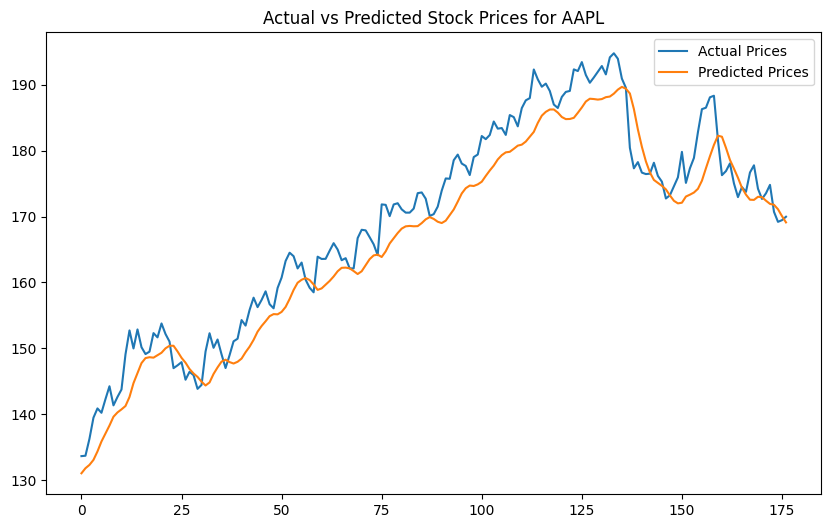

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import matplotlib.pyplot as plt

def evaluate_model(ticker, start_date, end_date, test_size=0.2):
    # Get stock data
    stock_data = get_stock_data(ticker, start_date, end_date)
    X, y, scaler = prepare_data(stock_data)

    # Split the data into training and testing sets
    split_index = int(len(X) * (1 - test_size))
    X_train, X_test = X[:split_index], X[split_index:]
    y_train, y_test = y[:split_index], y[split_index:]

    # Train the model
    model = build_gru_model((X.shape[1], 1))
    model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

    # Evaluate the model
    y_pred = model.predict(X_test)
    y_pred = scaler.inverse_transform(y_pred.reshape(-1, 1))
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)

    print(f"Mean Squared Error (MSE): {mse:.2f}")
    print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
    print(f"Mean Absolute Error (MAE): {mae:.2f}")

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label="Actual Prices")
    plt.plot(y_pred, label="Predicted Prices")
    plt.legend()
    plt.title(f"Actual vs Predicted Stock Prices for {ticker}")
    plt.show()

# Example usage
evaluate_model("AAPL", "2020-01-01", "2023-10-01")